# Exercise

Modify the code as per the below instructions
- Use a different dataset.
- Choose a different embedding like word2vec or gensim, if applicable.
- Modify the architecture, as below
    - Single layer of GRU and FC
    - Two layers of GRU and FC
- Change the number of GRU units in each layer.


In [ ]:
# Importing Libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
# Generate a mock dataset
np.random.seed(0)
time_steps = 1000
data = np.random.randn(time_steps)
dates = pd.date_range('20230101', periods=time_steps, freq='H')
mock_data = pd.DataFrame(data, index=dates, columns=['Measurement'])

# Preprocess the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(mock_data)

# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

reframed = series_to_supervised(scaled_data, 1, 1)

# Split into train and test sets
values = reframed.values
n_train_hours = int(len(values) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# Split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

# Reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print('shape of input data')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

shape of input data
(799, 1, 1) (799,) (200, 1, 1) (200,)


In [ ]:
# Define the RNN architecture with one GRU layers
model = keras.models.Sequential()
model.add(keras.layers.GRU(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dense(1))

print('\nmodel with one GRU')
# Display the model's architecture
model.summary()

# Define the RNN architecture with two GRU layers
model2 = keras.models.Sequential()
model2.add(keras.layers.GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model2.add(keras.layers.GRU(32, return_sequences=False))
model2.add(keras.layers.Dense(1))

print('\nmodel with two GRU')
# Display the model2's architecture
model2.summary()



model with one GRU
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 64)                12864     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12929 (50.50 KB)
Trainable params: 12929 (50.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

model with two GRU
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 1, 64)             12864     
                                                                 
 gru_7 (GRU)                 (None, 32)                9408      
                      

In [ ]:
# Compile the model
model.compile(loss='mae', optimizer='adam', metrics=['mae'])
model2.compile(loss='mae', optimizer='adam', metrics=['mae'])

# Train the model
print('--------------------------------------------model training with one GRU----------------------------------------------------------')
history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=1)
print('--------------------------------------------model training with two GRU----------------------------------------------------------')
history2 = model2.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=1)



--------------------------------------------model training with one GRU----------------------------------------------------------
Epoch 1/50
12/12 [==============================] - 3s 52ms/step - loss: 0.5158 - mae: 0.5158 - val_loss: 0.4589 - val_mae: 0.4589
Epoch 2/50
12/12 [==============================] - 0s 6ms/step - loss: 0.3747 - mae: 0.3747 - val_loss: 0.3132 - val_mae: 0.3132
Epoch 3/50
12/12 [==============================] - 0s 7ms/step - loss: 0.2424 - mae: 0.2424 - val_loss: 0.1803 - val_mae: 0.1803
Epoch 4/50
12/12 [==============================] - 0s 8ms/step - loss: 0.1566 - mae: 0.1566 - val_loss: 0.1333 - val_mae: 0.1333
Epoch 5/50
12/12 [==============================] - 0s 7ms/step - loss: 0.1424 - mae: 0.1424 - val_loss: 0.1340 - val_mae: 0.1340
Epoch 6/50
12/12 [==============================] - 0s 7ms/step - loss: 0.1428 - mae: 0.1428 - val_loss: 0.1319 - val_mae: 0.1319
Epoch 7/50
12/12 [==============================] - 0s 8ms/step - loss: 0.1407 - mae: 0.1

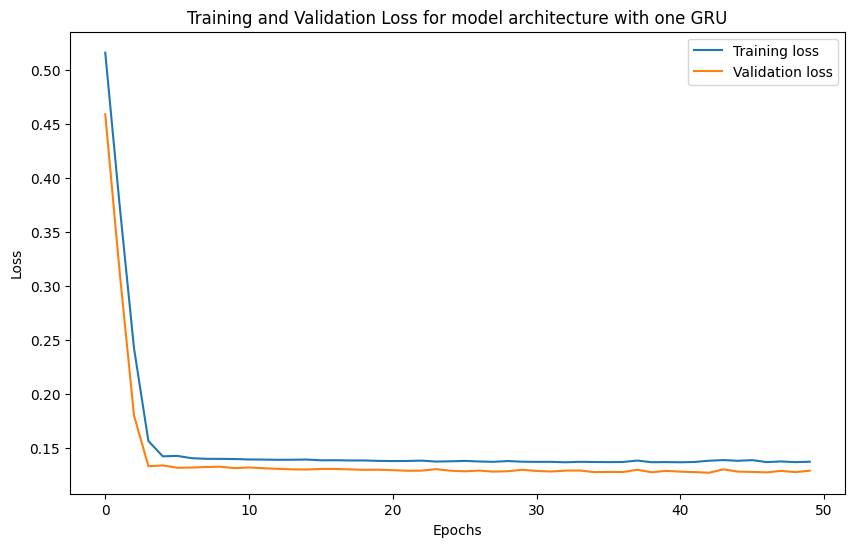

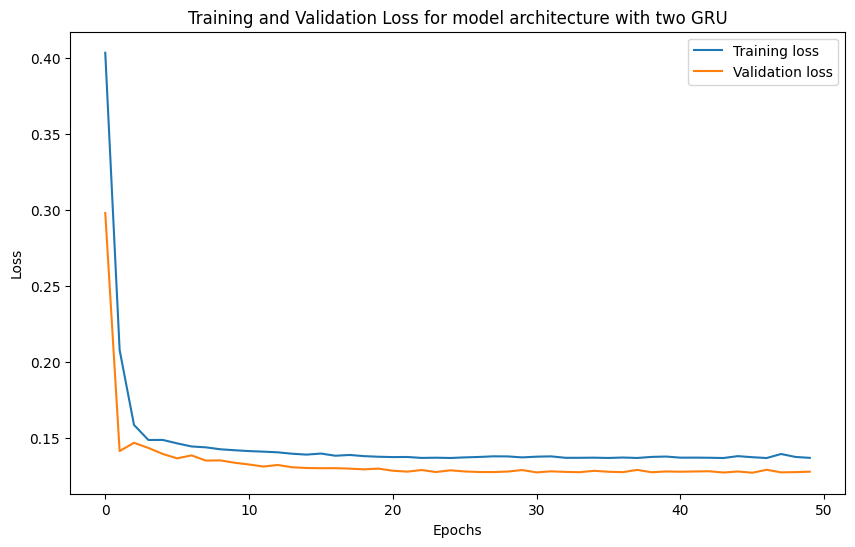

In [ ]:
# Plotting training and validation loss for model architecture with one GRU
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss for model architecture with one GRU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Plotting training and validation loss for model architecture with two GRU
plt.figure(figsize=(10, 6))
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss for model architecture with two GRU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:
# Evaluate the model with one GRU
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss model with one GRU: {test_loss}, Test MAE model with one GRU: {test_mae}')

# Evaluate the model with two GRU
test_loss2, test_mae2 = model2.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss model with two GRU: {test_loss2}, Test MAE model with two GRU: {test_mae2}')

Test Loss model with one GRU: 0.12915340065956116, Test MAE model with one GRU: 0.12915340065956116
Test Loss model with two GRU: 0.12791642546653748, Test MAE model with two GRU: 0.12791642546653748
